In [1]:
import numpy as np

In [2]:
class KNN(object):
    def __init__(self, n_neighbors = 5):
        self.k = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        dists = self.compute_distances(X)
        pred = self.predict_labels(dists)
        return pred

    def compute_distances(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.X_train, axis=2)

    def predict_labels(self, dists):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:self.k]].ravel())
            y_pred[i]= (np.argmax(np.bincount(closest_y)))
        return y_pred

In [3]:
import tensorflow
from tensorflow import keras

(X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

2023-10-28 09:29:11.440025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-28 09:29:17.472458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
X_test.shape

(10000, 28, 28)

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
from sklearn.utils import shuffle

x_test = np.reshape(X_test, (10000, 28 * 28))
x_train = np.reshape(X_train, (60000, 28 * 28))

x_test, y_test = shuffle(x_test, y_test, random_state=10)
x_train, y_train = shuffle(x_train, y_train, random_state=10)

x_test.shape, x_train.shape

((10000, 784), (60000, 784))

In [7]:
def half_noise(noise, data):
    data[:, :data.shape[1] // 2] += noise

def random_noise(low, high, data):
    return data + np.random.uniform(low, high, data.shape)

In [8]:
from sklearn.metrics import accuracy_score

t_split = 10000
p_split = 100

model = KNN(7)
model.fit(x_train[:t_split], y_train[:t_split])

y_pred1 = model.predict(x_test[:p_split])
accuracy_score(y_test[:p_split], y_pred1)

0.95

In [9]:
x_trc = x_train.copy()
x_tec = x_test.copy()

half_noise(80, x_trc)
half_noise(80, x_tec)

model = KNN(7)
model.fit(x_trc[:t_split], y_train[:t_split])

y_pred2 = model.predict(x_tec[:p_split])
accuracy_score(y_test[:p_split], y_pred2)

0.95

In [10]:
x_trc1 = random_noise(10, 50, x_train)
x_tec1 = random_noise(10, 50, x_test)

model = KNN(7)
model.fit(x_trc1[:t_split], y_train[:t_split])

y_pred3 = model.predict(x_tec1[:p_split])

accuracy_score(y_test[:p_split], y_pred3)

0.95

In [26]:
def check_vibrosi(x, y):
    model = KNN(7)
    out = []
    for i in range(x.shape[0]):
        x_outlier = np.delete(x, i, axis=0)
        y_outlier = np.delete(y, i, axis=0)
        
        model.fit(x_outlier, y_outlier)
        y_out_pred = model.predict(x[i].reshape(1, x[i].shape[0]))
        
        if y_out_pred[0] != y[i]:
            out.append(i)
    
    return out

split = 1000
vibr = check_vibrosi(x_train[:split], y_train[:split])

In [19]:
def show_images_outliers(images):
    from matplotlib import pyplot
    pyplot.subplots(figsize=(28, 28))
    for i, im in enumerate(images):
        tm_re = im.reshape((28, 28))
        pyplot.subplot(16, 16, 1 + i)
        pyplot.imshow(tm_re, cmap=pyplot.get_cmap('gray'), vmin=0, vmax=255)
    pyplot.show()

In [15]:
#ODIN
import sklearn.neighbors as neighbors
import numpy as np
def iqr_threshold_method(scores, margin):
    q1 = np.percentile(scores, 25, method='midpoint')
    q3 = np.percentile(scores, 75, method='midpoint')
    iqr = q3-q1
    lower_range = q1 - (1.5 * iqr)
    upper_range = q3 + (1.5 * iqr)
    lower_range = lower_range - margin
    upper_range = upper_range + margin
    return lower_range, upper_range

def OdinOutlier(
    x,
    y,
    margin=0,
    n_neighbors=5,
    radius=1.0,
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    p=2,
    metric_params=None,
    n_jobs=None
):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors, radius=radius, algorithm=algorithm, leaf_size=leaf_size, metric=metric, p=p, metric_params=metric_params, n_jobs=n_jobs)

    nn.fit(x, y)
    graph = nn.kneighbors_graph()
    indegree = graph.sum(axis=0) # sparse matrix

    # smaller indegree means more of an anomaly
    # simple conversion to [0,1] so larger score is more of anomaly
    scores = (indegree.max() - indegree) / indegree.max()
    scores = np.array(scores)[0]

    lower_range, upper_range = iqr_threshold_method(scores, margin)

    anomaly_points = []
    for i in range(len(scores)):
        if scores[i] < lower_range or scores[i] > upper_range:
            anomaly_points.append(i)

    return anomaly_points

odin = OdinOutlier(x_train[:split], y_train[:split], n_neighbors=5)
print(odin)

[106, 353, 372, 561, 935]


/tmp/ipykernel_9713/1787365688.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 16, 1 + i)


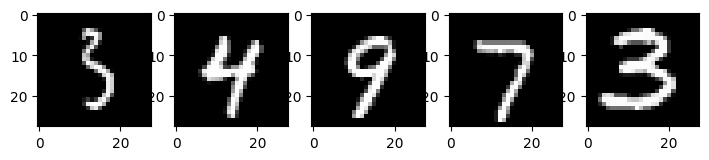

In [20]:
show_images_outliers(x_train[odin])

/tmp/ipykernel_9713/1787365688.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 16, 1 + i)


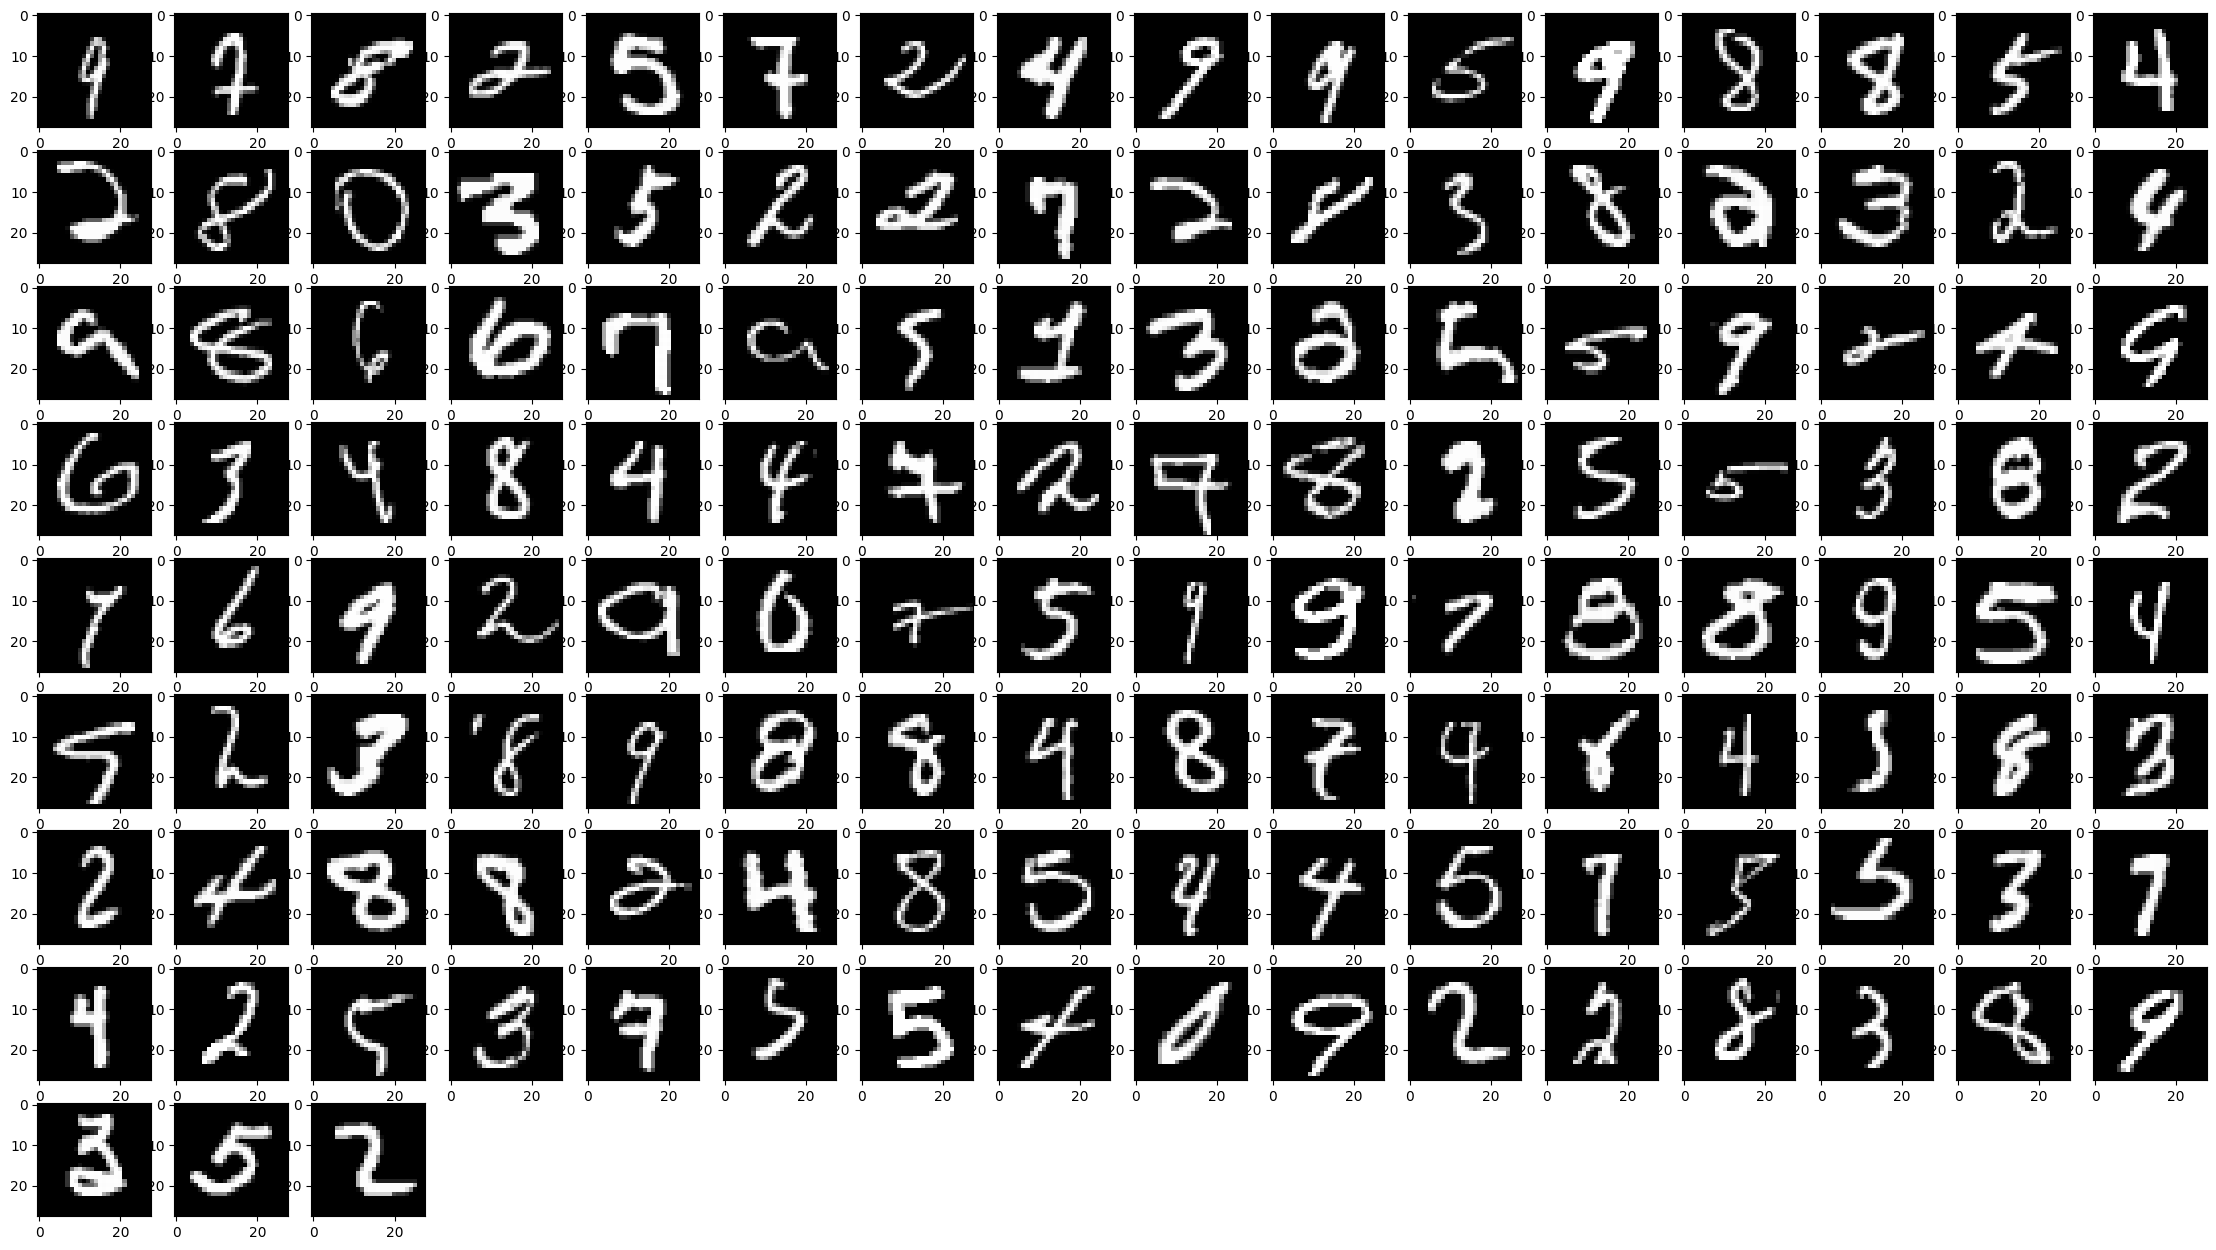

In [27]:
show_images_outliers(x_train[vibr])